# Heat Transfer Surrogate Model (Project 2)

## Problem Statement

## Physics Model

This project uses a 1D steady-state heat transfer model for conduction through a
plane wall with convection on both sides. The analytical model serves as the
ground truth used to generate synthetic data. A machine learning surrogate model
is later trained to approximate the mapping from physical parameters to heat flux.

### Assumptions
- Steady-state (no time dependence)
- One-dimensional heat flow
- Constant material properties (k is constant)
- No internal heat generation
- Contact resistance is neglected
- Convection on both sides is represented by constant h values

### Thermal Resistance Network
The total thermal resistance per unit area is:

R_total = 1/h_hot + L/k + 1/h_cold

### Heat Flux
The resulting heat flux is:

q'' = (T_hot - T_cold) / R_total

In [9]:
# Physics model prediction computed directly in the notebook
R_total = (
    1.0 / df["Hot-Side h (W/m²·K)"] +
    df["Wall Thickness (m)"] / df["Thermal Conductivity (W/m·K)"] +
    1.0 / df["Cold-Side h (W/m²·K)"]
)

q_physics = (
    (df["Hot Ambient Temperature (°C)"] - df["Cold Ambient Temperature (°C)"]) / R_total
)

# Check that it matches the dataset target
diff = q_physics - df["Heat Flux (W/m²)"]
diff.abs().describe()

count    2.000000e+03
mean     2.788378e-13
std      5.637878e-13
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.547474e-13
max      5.456968e-12
dtype: float64

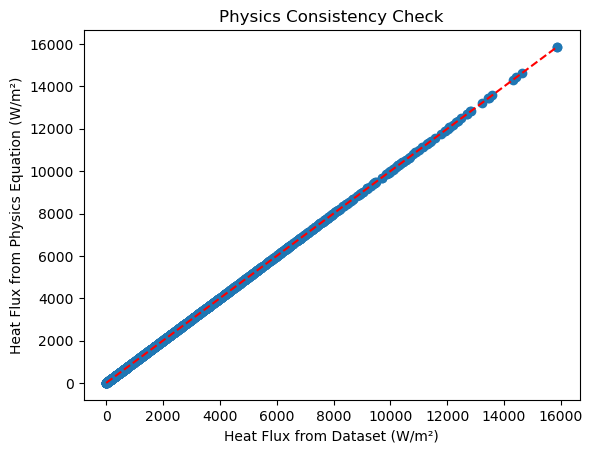

In [13]:
import matplotlib.pyplot as plt

plt.scatter(df["Heat Flux (W/m²)"], q_physics)
plt.plot(
    [df["Heat Flux (W/m²)"].min(), df["Heat Flux (W/m²)"].max()],
    [df["Heat Flux (W/m²)"].min(), df["Heat Flux (W/m²)"].max()],
    "r--"
)
plt.xlabel("Heat Flux from Dataset (W/m²)")
plt.ylabel("Heat Flux from Physics Equation (W/m²)")
plt.title("Physics Consistency Check")
plt.show()

The computed physics heat flux matches the dataset target, confirming that the
dataset is consistent with the analytical heat transfer model.

## Generate Dataset

In [15]:
import pandas as pd

df = pd.read_csv("../data/raw/heat_transfer_dataset.csv")
df = df.rename(columns={
    "k_W_mK": "Thermal Conductivity (W/m·K)",
    "L_m": "Wall Thickness (m)",
    "h1_W_m2K": "Hot-Side h (W/m²·K)",
    "h2_W_m2K": "Cold-Side h (W/m²·K)",
    "Tinf1_C": "Hot Ambient Temperature (°C)",
    "Tinf2_C": "Cold Ambient Temperature (°C)",
    "q_flux_W_m2": "Heat Flux (W/m²)"
})
df.head()

,Thermal Conductivity (W/m·K),Wall Thickness (m),Hot-Side h (W/m²·K),Cold-Side h (W/m²·K),Hot Ambient Temperature (°C),Cold Ambient Temperature (°C),Heat Flux (W/m²)
0,309.605024,0.168704,144.639494,93.817894,120.677840,69.280123,2836.896243
1,175.607488,0.089832,74.637541,28.177308,181.591533,68.236154,2294.681328
2,343.453308,0.190642,171.114232,115.988818,70.050524,12.296453,3844.979646
3,278.977475,0.130508,51.990546,35.503621,24.675961,-5.967907,640.171498
4,37.761521,0.024064,109.986731,16.886875,159.617901,23.417947,1975.433959


In [4]:
df.shape
df.describe()

,Thermal Conductivity (W/m·K),Wall Thickness (m),Hot-Side h (W/m²·K),Cold-Side h (W/m²·K),Hot Ambient Temperature (°C),Cold Ambient Temperature (°C),Heat Flux (W/m²)
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,201.184404,0.099151,100.194837,102.315465,114.977293,40.539217,2926.289800
std,116.150490,0.057680,55.470722,56.252101,46.879543,29.140990,2670.150999
min,0.307446,0.001128,5.061312,5.081299,20.760667,-9.998551,2.767309
25%,97.703839,0.049919,52.086516,54.546576,77.958425,17.218478,894.065312
50%,198.454911,0.099514,99.243256,102.843271,112.302782,38.505745,2157.615848
75%,304.509046,0.149385,147.583485,149.591203,153.862848,63.916037,4152.527108
max,399.768821,0.199953,199.944396,199.995519,199.830698,99.875886,15864.410374


In [5]:
(df["Heat Flux (W/m²)"] > 0).mean()

np.float64(1.0)

In [6]:
(df["Hot Ambient Temperature (°C)"] - df["Cold Ambient Temperature (°C)"]).corr(df["Heat Flux (W/m²)"])

np.float64(0.6937434866645786)

## Feature-Target Definition / Train-Test Split

The surrogate model learns a mapping from physical parameters governing heat transfer to the resulting heat flux through the wall.

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Heat Flux (W/m²)"])
y = df["Heat Flux (W/m²)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((1600, 6), (400, 6))

## Baseline Surrogate Model (Linear Regression)

A linear regression model is trained as a baseline to approximate the physics-based heat transfer relationship.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(1324.868488455334), 0.7623866943616693)

## Baseline Surrogate Model vs. Physics Model

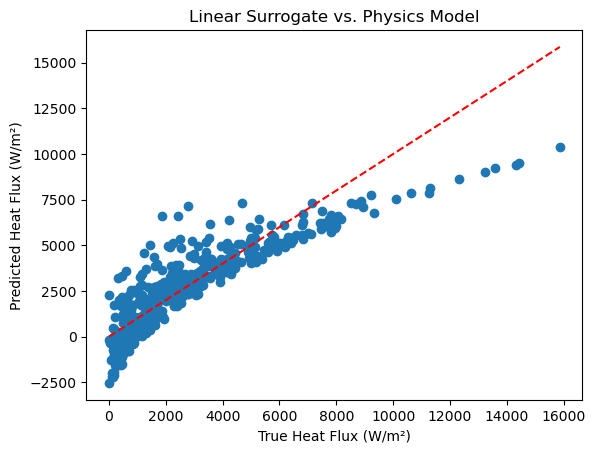

In [11]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.xlabel("True Heat Flux (W/m²)")
plt.ylabel("Predicted Heat Flux (W/m²)")
plt.title("Linear Surrogate vs. Physics Model")
plt.show()

The linear surrogate captures the general trend of the physics model but exhibits
systematic curvature, particularly at higher heat flux values. This behavior is
consistent with the inverse relationship between heat flux and total thermal
resistance, which cannot be fully represented by a linear model due to the combined effects of multiple resistances.

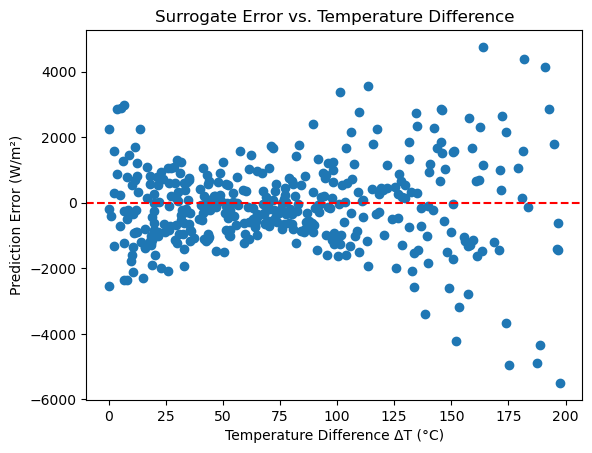

In [18]:
delta_T = X_test["Hot Ambient Temperature (°C)"] - X_test["Cold Ambient Temperature (°C)"]
error = y_pred - y_test

plt.scatter(delta_T, error)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Temperature Difference ΔT (°C)")
plt.ylabel("Prediction Error (W/m²)")
plt.title("Surrogate Error vs. Temperature Difference")
plt.show()

Prediction error remains centered around zero at low to moderate temperature
differences but increases in variance at larger ΔT values. This heteroscedastic
behavior reflects the inverse thermal resistance relationship in the governing
physics, which amplifies errors at higher heat flux.

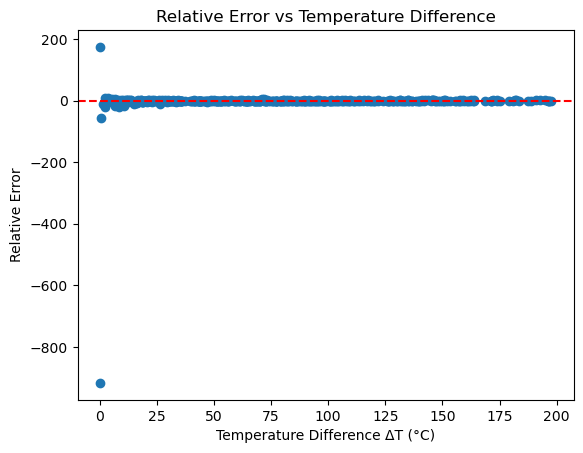

In [19]:
relative_error = (y_pred - y_test) / y_test

plt.scatter(delta_T, relative_error)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Temperature Difference ΔT (°C)")
plt.ylabel("Relative Error")
plt.title("Relative Error vs Temperature Difference")
plt.show()